# Emoji Hunt Challenge - Classical Methods
This notebook encapasulates our attempt at the emoji hunt challenge using classical computer vision methods, ie: not deep learning.

## Runtime environment
This notebook is intended to be run on Google collab which provides all of the packages this projects needs with exception to the emoji hunt challenge package. Running the cell below will install that package.

In [2]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt

Current project version:
emojihunt==1.1.1


## Implementation of method

In [27]:
import json
import matplotlib.pyplot as plt
import cv2
from emojihunt import *

### Load the test image and the target emoji
This step gets the test image and the emoji target from the challenge package then converts them both to the LAB colour space.

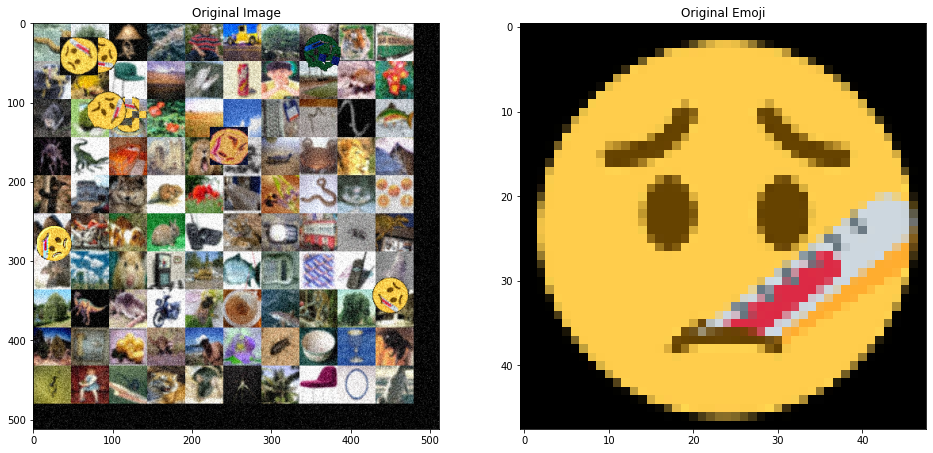

In [75]:
# Get image and emoji
emoji_hunt_object = EmojiHunt() 
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

# Convert to LAB
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
emoji_target = cv2.cvtColor(emoji_target, cv2.COLOR_BGR2LAB)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_LAB2RGB))
ax[0].set_title('Original Image')

ax[1].imshow(cv2.cvtColor(emoji_target, cv2.COLOR_LAB2RGB))
ax[1].set_title('Original Emoji')
plt.show()

### Segment both images using SLIC

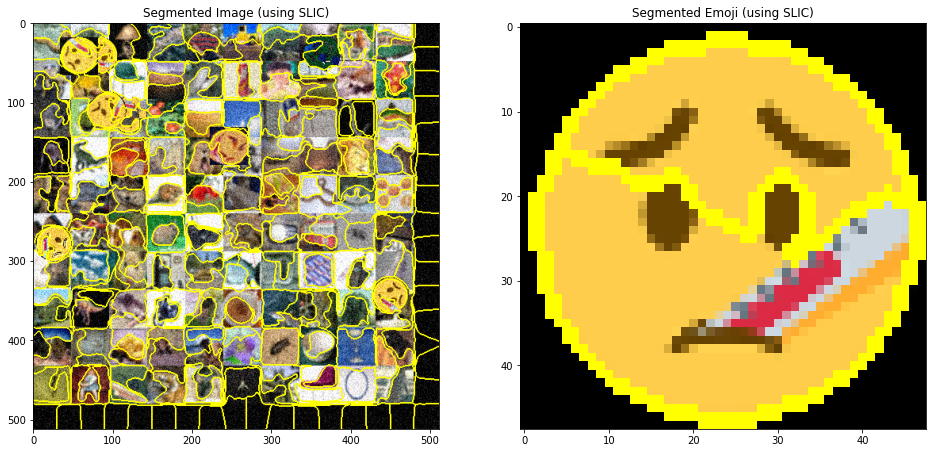

In [76]:
from skimage.segmentation import slic, mark_boundaries

rgb_image = cv2.cvtColor(test_image, cv2.COLOR_LAB2RGB)
rgb_emoji = cv2.cvtColor(emoji_target, cv2.COLOR_LAB2RGB)

segmented_image = slic(rgb_image, n_segments=300, compactness=10, sigma=3)
segmented_emoji = slic(rgb_emoji, n_segments=5)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].imshow(mark_boundaries(rgb_image, segmented_image))
ax[0].set_title('Segmented Image (using SLIC)')

ax[1].imshow(mark_boundaries(rgb_emoji, segmented_emoji))
ax[1].set_title('Segmented Emoji (using SLIC)')
plt.show()

### Compute the average colour of each super pixel in the segmented images

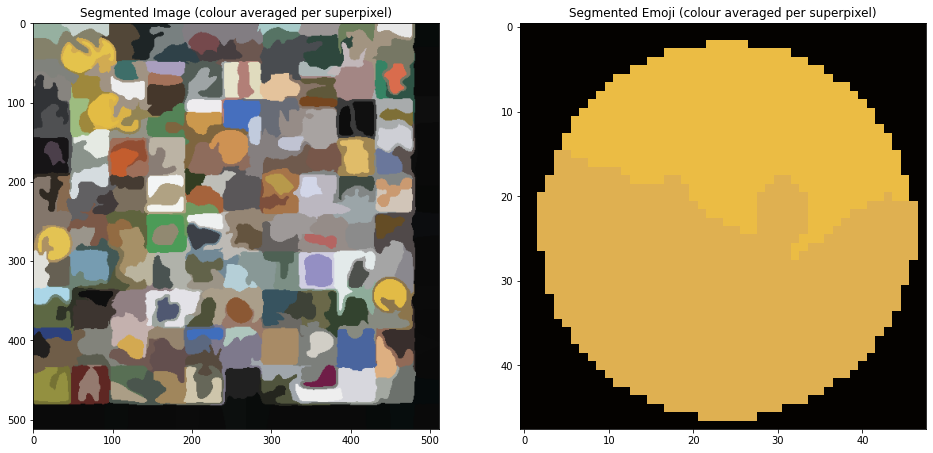

In [77]:
def average_super_pixels(original_image, segmented_image):
    # Given the original image (in the LAB color space) and its segmented
    # counterpart return an image where each pixel within a super pixel has
    # been set to the average colour of that superpixel as well as a list of
    # the computed colour means for each segment

    n_segments = len(np.unique(segmented_image))
    segment_means = np.zeros((n_segments, 3))
    averaged_image = np.empty_like(original_image)

    for i in range(n_segments):
        segment_means[i] = np.mean(original_image[segmented_image == i + 1], axis=0)
        averaged_image[segmented_image == i + 1] = segment_means[i]

    return averaged_image, segment_means

color_averaged_image, image_segment_mean_colors = average_super_pixels(test_image, segmented_image)
color_averaged_emoji, emoji_segment_mean_colors = average_super_pixels(emoji_target, segmented_emoji)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].imshow(cv2.cvtColor(color_averaged_image, cv2.COLOR_LAB2RGB))
ax[0].set_title('Segmented Image (colour averaged per superpixel)')

ax[1].imshow(cv2.cvtColor(color_averaged_emoji, cv2.COLOR_LAB2RGB))
ax[1].set_title('Segmented Emoji (colour averaged per superpixel)')
plt.show()

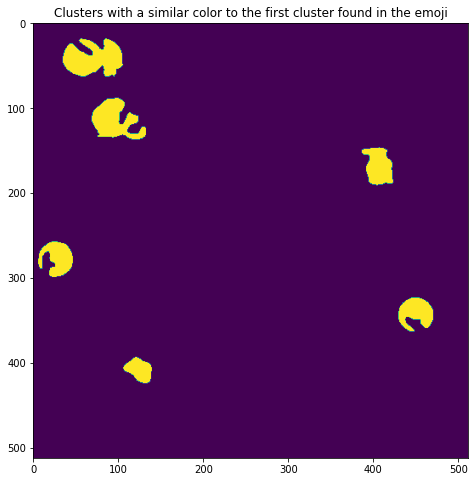

In [78]:
# Drop the background color from the emoji's average colors
emoji_segment_mean_colors = emoji_segment_mean_colors[1:]

# Find similar clusters
similarity_scores = np.zeros((color_averaged_image.shape[0], color_averaged_image.shape[1], color_averaged_image.shape[1]))
for y in range(color_averaged_image.shape[0]):
    for x in range(color_averaged_image.shape[1]):
        for c in range(emoji_segment_mean_colors.shape[0]):
            similarity_scores[y, x, c] = np.sqrt((emoji_segment_mean_colors[c, 0] - color_averaged_image[y, x, 0])**2 + (emoji_segment_mean_colors[c, 1] - color_averaged_image[y, x, 1])**2 + (emoji_segment_mean_colors[c, 2] - color_averaged_image[y, x, 2])**2)

# Map similar clusters to an image to find the emojis!
found_emojis = np.zeros((color_averaged_image.shape[0], color_averaged_image.shape[1]), dtype=int)
found_emojis[similarity_scores[:,:,0] < np.min(similarity_scores[:,:,0]) + 25] = 1

# Plot the mask found showing where emojis are for the first group of similar clusters
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(found_emojis)
ax.set_title('Clusters with a similar color to the first cluster found in the emoji')
plt.show()

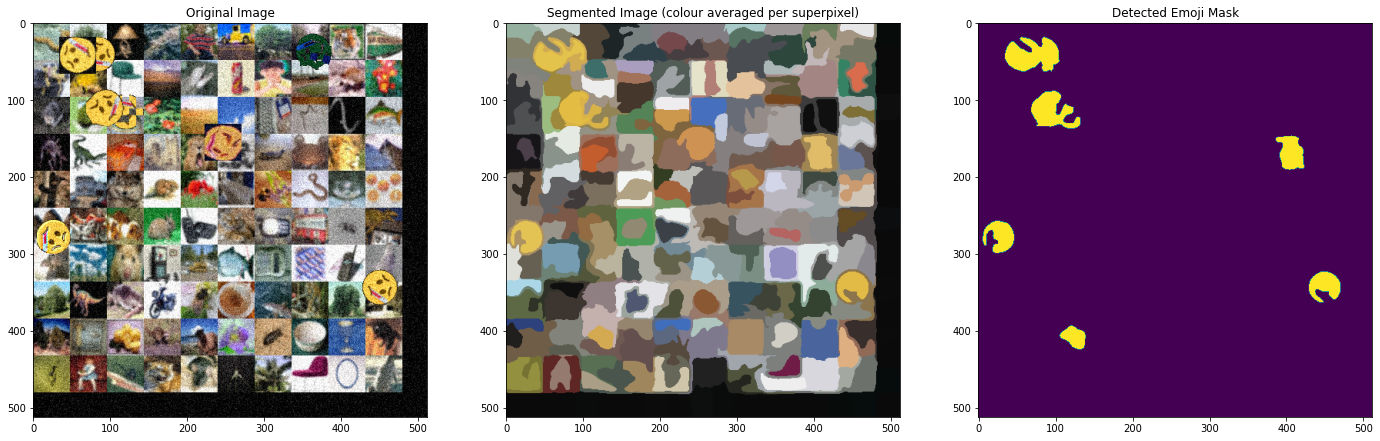

In [79]:
# Bringing it all together into one graph
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
ax[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_LAB2RGB))
ax[0].set_title('Original Image')

ax[1].imshow(cv2.cvtColor(color_averaged_image, cv2.COLOR_LAB2RGB))
ax[1].set_title('Segmented Image (colour averaged per superpixel)')

ax[2].imshow(found_emojis)
ax[2].set_title('Detected Emoji Mask')
plt.show()